In [6]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np

import copy

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Is CUDA supported by this system? True


In [7]:
# https://github.com/kuangliu/pytorch-cifar/issues/19
test_t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]
)

test_data  = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True,
    transform=test_t
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=48, shuffle=False
)

Files already downloaded and verified


In [21]:
class Block(nn.Module):
    def __init__(self, channel_in, pass_on, channel_out, device):
        super().__init__()
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(channel_in, channel_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(channel_out["1x1"]),
            nn.PReLU()
        )
    
        # 3x3 branch, we padding 1 in the 3x3 convolution layer to keep same size of image
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(channel_in, pass_on["3x3"], kernel_size=1),
            nn.BatchNorm2d(pass_on["3x3"]),
            nn.PReLU(),
            nn.Conv2d(pass_on["3x3"], channel_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(channel_out["3x3"]),
            nn.PReLU()
        )
        
        # 5x5 branch, we padding 2 in the 5x5 convolution layer to keep same size of image
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(channel_in, pass_on["5x5"], kernel_size=1),
            nn.BatchNorm2d(pass_on["5x5"]),
            nn.PReLU(),
            nn.Conv2d(pass_on["5x5"], channel_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(channel_out["5x5"]),
            nn.PReLU()
        ) 
        # Max pooling branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(channel_in, channel_out["max"], kernel_size=1),
            nn.BatchNorm2d(channel_out["max"]),
            nn.PReLU()
        )

        self._initialize_weights()

    def forward(self, x):
        return torch.cat(
            [
                self.conv_1x1(x), self.conv_3x3(x),
                self.conv_5x5(x), self.max_pool(x)
            ], dim=1 # concatenate along channels
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.1)
                nn.init.constant_(m.bias, 0)

# https://arxiv.org/pdf/1502.01852.pdf
# https://arxiv.org/pdf/1409.4842.pdf

class CifarGoogle(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 n_classes=10,
                 device='cpu', 
                 lr=0.01):
        super(CifarGoogle, self).__init__()
        
        self.seq = nn.Sequential(
            # input layer
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.PReLU(),
            nn.LocalResponseNorm(128),
            nn.Conv2d(64, 112, kernel_size=1),
            nn.PReLU(),
            nn.Conv2d(112, 196, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.LocalResponseNorm(128),
            # pass through blocks
            Block(
                196, 
                pass_on={"3x3": 96, "5x5": 16}, 
                channel_out={"1x1": 64, "3x3": 128, "5x5": 32, "max": 32},
                device=device
            ),
            Block(
                256, 
                pass_on={"3x3": 128, "5x5": 32}, 
                channel_out={"1x1": 128, "3x3": 192, "5x5": 96, "max": 64},
                device=device
            ),
            # reduce dimensions
            nn.MaxPool2d(3, stride=2, padding=1),  
            # pass through blocks
            Block(
                480, 
                pass_on={"3x3": 96, "5x5": 16}, 
                channel_out={"1x1": 192, "3x3": 208, "5x5": 48, "max": 64}, 
                device=device
            ),
            Block(
                512, 
                pass_on={"3x3": 112, "5x5": 24}, 
                channel_out={"1x1": 160, "3x3": 224, "5x5": 64, "max": 64}, 
                device=device
            ),
            Block(
                512, 
                pass_on={"3x3": 128, "5x5": 24}, 
                channel_out={"1x1": 128, "3x3": 256, "5x5": 64, "max": 64}, 
                device=device
            ),
            Block(
                512, 
                pass_on={"3x3": 112, "5x5": 32}, 
                channel_out={"1x1": 112, "3x3": 288, "5x5": 64, "max": 64}, 
                device=device
            ),
            # reduce dimensions
            nn.MaxPool2d(3, stride=2, padding=1),
            # pass through last blocks
            Block(
                528, 
                pass_on={"3x3": 160, "5x5": 32}, 
                channel_out={"1x1": 256, "3x3": 320, "5x5": 128, "max": 128},
                device=device
            ),
            Block(
                832, 
                pass_on={"3x3": 150, "5x5": 42}, 
                channel_out={"1x1": 266, "3x3": 330, "5x5": 108, "max": 128},
                device=device
            ),
            # pool
            nn.AdaptiveAvgPool2d((1, 1)),
            # classification head
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(832, 10),
            nn.Softmax(1)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss().to(device)

        self.device = device
        self.n_classes = n_classes

        self.total_epochs_trained = 0

        self._initialize_weights()

        self.max_test_acc = -9e15

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.seq(x)

    def train(self, train_loader, test_loader, train_epochs):
        break_count = 0
        max_break_count = 15
        epoch_train_loss = epoch_test_loss = 0
        epoch_train_losses = []
        epoch_test_losses = []

        state_dict = None

        self.training = True
        for module in self.children():
            module.train(True)

        for epoch in range(train_epochs):
            total_train_loss = total_test_acc = 0
            for image,label in train_loader:
                image = image.to(self.device)
                label = label.to(self.device)

                self.optimizer.zero_grad()

                preds = self.forward(image)

                loss = self.criterion(preds, label)
                total_train_loss += loss.item()
                loss.backward()

                self.optimizer.step()
            
            with torch.no_grad():
                self.training = False
                for module in self.children():
                    module.train(False)
                
                for image,label in test_loader:
                    image = image.to(self.device)
                    label = label.to(self.device)

                    preds = self.forward(image)

                    total_test_acc += (
                        torch.sum(torch.argmax(preds, dim=1) == label).item()
                    )
                    
                self.training = True
                for module in self.children():
                    module.train(True)

            total_test_acc /= test_loader.dataset.data.shape[0]

            self.total_epochs_trained += 1

            print(f'''[Epoch {epoch} / Global Epoch {self.total_epochs_trained}]''')
            print(f'''    Train Loss:     {total_train_loss}''')
            print(f'''    Test Accuracy:  {total_test_acc}''')

            if (total_test_acc > self.max_test_acc):
                self.max_test_acc = total_test_acc
                state_dict = copy.deepcopy(self.state_dict())
                break_count = 0
            else:
                break_count += 1
                if break_count >= max_break_count:
                    print("Stopping Early.")
                    break

            print(f'''    Best Test Acc:  {self.max_test_acc}\n''')
        self.load_state_dict(state_dict)

    def predict(self, test_loader):
        self.training = False
        for module in self.children():
            module.train(False)

        results = torch.empty((0,10)).to(self.device)
        acc = 0
        with torch.no_grad():
            for image,label in test_loader:
                image = image.to(self.device)
                label = label.to(self.device)

                preds = self.forward(image)

                results = torch.cat((results, preds), 0).to(self.device)

                acc += (
                    torch.sum(torch.argmax(preds, dim=1) == label).item()
                )
        
        acc /= results.shape[0]
        
        return results, acc

In [22]:
mybing = CifarGoogle(
    in_channels=3, 
    n_classes=10,
    device=DEVICE,
    lr=0.0001
).to(DEVICE)

In [23]:
best_model_dict = torch.load("model_large_100.pt")

mybing.load_state_dict(best_model_dict['model_state'])
mybing.optimizer.load_state_dict(best_model_dict['optimizer_state'])
mybing.total_epochs_trained = best_model_dict['epoch']
mybing.max_test_acc = best_model_dict['acc']

print(mybing.total_epochs_trained)
print(mybing.max_test_acc)

100
0.9033


In [24]:
results, accuracy = mybing.predict(test_loader)
print(accuracy)

0.8972


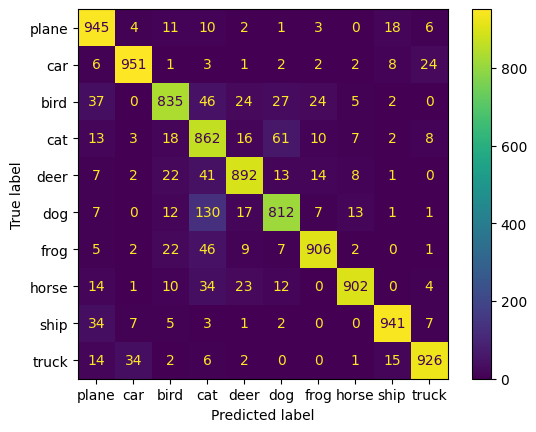

In [36]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(
    test_loader.dataset.targets, 
    torch.argmax(results, dim=1).to('cpu').detach().numpy()
)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix,
    display_labels=('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
)
cm_display.plot()
plt.show()